# 학생들의 기본 피쳐만 가지고 상관관계 분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 로드
df = pd.read_csv('./data/studentInfo.csv')

# 안쓰는 컬럼 삭제
df = df.drop(['code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits'], axis=1)

# 모든 컬럼이 같은 행을 삭제
df = df.drop_duplicates(subset=df.columns.difference(['final_result']), keep='first').reset_index(drop=True)
df.duplicated(subset=df.columns.difference(['final_result'])).sum()

# withdrawn이면 1, 아니면 0 인 dropout_status 컬럼 생성
df['dropout_status'] = np.where(df['final_result'] == 'Withdrawn', 1, 0)
df = df.drop(['final_result'], axis=1)
df = df.drop_duplicates(keep='first').reset_index(drop=True)
df.duplicated().sum()

# 중복 행 제거
ids_with_both = df.groupby('id_student')['dropout_status'].nunique()
ids_with_both = ids_with_both[ids_with_both > 1].index
df = df[~df['id_student'].isin(ids_with_both)].reset_index(drop=True)

### 데이터 전처리 함수

In [2]:
def preprocess_features(data):
    # ----- 매핑 딕셔너리 -----
    gender_map = {'F': 0, 'M': 1}
    disability_map = {'N': 0, 'Y': 1}
    age_band_map = {'0-35': 0, '35-55': 1, '55<=': 2}
    he_map = {
        'No Formal quals': 0,
        'Lower Than A Level': 1,
        'A Level or Equivalent': 2,
        'HE Qualification': 3,
        'Post Graduate Qualification': 4
    }
    imd_map = {
        '0-10%': 1, '10-20': 2, '20-30%': 3, '30-40%': 4, '40-50%': 5,
        '50-60%': 6, '60-70%': 7, '70-80%': 8, '80-90%': 9, '90-100%': 10
    }
    region_map = {
        'East Anglian Region': 0,
        'East Midlands Region': 1,
        'Ireland': 2,
        'London Region': 3,
        'North Region': 4,
        'North Western Region': 5,
        'Scotland': 6,
        'South East Region': 7,
        'South Region': 8,
        'South West Region': 9,
        'Wales': 10,
        'West Midlands Region': 11,
        'Yorkshire Region': 12
    }

    # ----- 2) 라벨 인코딩 -----
    data['gender'] = data['gender'].map(gender_map)
    data['disability'] = data['disability'].map(disability_map)
    data['age_band'] = data['age_band'].map(age_band_map)
    data['highest_education'] = data['highest_education'].map(he_map)

    data['imd_band'] = data['imd_band'].replace('?', pd.NA).map(imd_map)
    data = data.dropna(subset=['imd_band'])  # '?'가 있던 행 제거

    data['region'] = data['region'].map(region_map)

    return data

In [3]:
# 데이터 전처리 수행
df = preprocess_features(df)

C:\Users\user\AppData\Local\Temp\ipykernel_2584\848437386.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['region'] = data['region'].map(region_map)


In [4]:
# age_band 가 0과 1이 모두 있는 행 삭제
ids_with_both = df.groupby('id_student')['age_band'].nunique()
ids_with_both = ids_with_both[ids_with_both > 1].index
df = df[~df['id_student'].isin(ids_with_both)].reset_index(drop=True)
df

,id_student,gender,region,highest_education,imd_band,age_band,disability,dropout_status
0,11391,1,0,3,10.0,2,0,0
1,28400,0,6,3,3.0,1,0,0
2,30268,0,5,2,4.0,1,1,1
3,31604,0,7,2,6.0,1,0,0
4,32885,0,11,1,6.0,0,0,0
...,...,...,...,...,...,...,...,...
27746,2640965,0,10,1,2.0,0,0,0
27747,2645731,0,0,1,5.0,1,0,0
27748,2648187,0,8,2,3.0,0,1,0
27749,2679821,0,7,1,10.0,1,0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27751 entries, 0 to 27750
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_student         27751 non-null  int64  
 1   gender             27751 non-null  int64  
 2   region             27751 non-null  int64  
 3   highest_education  27751 non-null  int64  
 4   imd_band           27751 non-null  float64
 5   age_band           27751 non-null  int64  
 6   disability         27751 non-null  int64  
 7   dropout_status     27751 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 1.7 MB


In [6]:
df.isnull().sum()

id_student           0
gender               0
region               0
highest_education    0
imd_band             0
age_band             0
disability           0
dropout_status       0
dtype: int64

In [7]:
df.to_csv('data_features.csv')

### 데이터 학습 및 평가 

In [16]:
# 데이터 분리 & 평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score

# 분류 모델들
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# 부스팅 계열
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [17]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [18]:
X = df.drop(['dropout_status', 'id_student'], axis=1)
y = df['dropout_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
# === 1. 비교 모델 세트 ===
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),  
    "XGBoost": XGBClassifier(
        random_state=42,
        eval_metric="logloss"
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [25]:
# --- 2) 학습 & 평가 유틸 ---
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

# --- 3) 전체 모델 실행 ---
rows = []
reports = {}
for name, m in models.items():
    try:
        row, rep = eval_model(name, m, X_train, y_train, X_test, y_test)
        rows.append(row)
        reports[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (no stratify, no scaling) ===")
print(df_results.to_string(index=False))

best_model_name = df_results.iloc[0]["Model"]
print(f"\nBest (by ROC-AUC): {best_model_name}")

=== Model comparison (no stratify, no scaling) ===
           Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
GradientBoosting  0.681464      0.407895   0.014117 0.027289 0.588619  31  45 4697 2165
         XGBoost  0.679158      0.461735   0.082423 0.139876 0.564365 181 211 4531 2015
    RandomForest  0.660853      0.399230   0.141621 0.209076 0.542940 311 468 4274 1885
    DecisionTree  0.666186      0.395833   0.103825 0.164502 0.540689 228 348 4394 1968
             KNN  0.634621      0.371494   0.223133 0.278805 0.537551 490 829 3913 1706

Best (by ROC-AUC): GradientBoosting


In [31]:
df11= pd.DataFrame(reports['GradientBoosting'])
print(df11.T)

              precision    recall  f1-score      support
0              0.684494  0.990510  0.809548  4742.000000
1              0.407895  0.014117  0.027289  2196.000000
accuracy       0.681464  0.681464  0.681464     0.681464
macro avg      0.546195  0.502313  0.418419  6938.000000
weighted avg   0.596946  0.681464  0.561949  6938.000000


In [26]:
print(classification_report(y_test, y_pred, digits=4))

NameError: name 'y_pred' is not defined

---

### polynomial features 생성으로 성능 향상 과정

In [70]:
X = df.drop(['dropout_status', 'id_student'], axis=1)
y = df['dropout_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, random_state=42, stratify=y)

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# === 1. 비교 모델 세트 ===
models = {
    # --- 선형 모델 + PolynomialFeatures ---
    "LogisticRegression_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        LogisticRegression(max_iter=1000, random_state=42)
    ),
    "RidgeClassifier_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        RidgeClassifier(random_state=42)
    ),

    # --- 트리 계열 (PolynomialFeatures 넣어도 영향은 적지만 비교용) ---
    "DecisionTree_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        DecisionTreeClassifier(random_state=42)
    ),
    "RandomForest_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        RandomForestClassifier(random_state=42)
    ),
    "GradientBoosting_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        GradientBoostingClassifier(random_state=42)
    ),
    "XGBoost_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        XGBClassifier(random_state=42, eval_metric="logloss")
    )
}

In [72]:
# --- 2) 학습 & 평가 유틸 ---
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

# --- 3) 전체 모델 실행 ---
rows = []
reports = {}
for name, m in models.items():
    try:
        row, rep = eval_model(name, m, X_train, y_train, X_test, y_test)
        rows.append(row)
        reports[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (no stratify, scaling) ===")
print(df_results.to_string(index=False))

best_model_name = df_results.iloc[0]["Model"]
print(f"\nBest (by ROC-AUC): {best_model_name}")

=== Model comparison (no stratify, scaling) ===
                  Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
  GradientBoosting_poly  0.681320      0.415730   0.016849 0.032385 0.589155  37  52 4690 2159
LogisticRegression_poly  0.683915      0.519481   0.018215 0.035196 0.582029  40  37 4705 2156
   RidgeClassifier_poly  0.683626      0.507463   0.015483 0.030049 0.582013  34  33 4709 2162
           XGBoost_poly  0.674258      0.424171   0.081512 0.136746 0.562770 179 243 4499 2017
      RandomForest_poly  0.661430      0.402299   0.143443 0.211480 0.543060 315 468 4274 1881
      DecisionTree_poly  0.666186      0.395833   0.103825 0.164502 0.540670 228 348 4394 1968

Best (by ROC-AUC): GradientBoosting_poly


In [73]:
# --- 3) 전체 모델 실행 ---
rows = []
reports = {}
for name, m in models.items():
    try:
        row, rep = eval_model(name, m, X_train_strat, y_train_strat, X_test_strat, y_test_strat)
        rows.append(row)
        reports[name] = rep
    except Exception as e:
        print(f"[WARN] {name} 실행 중 오류 → 스킵: {e}")

df_results = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)
print("=== Model comparison (stratify, scaling) ===")
print(df_results.to_string(index=False))

best_model_name = df_results.iloc[0]["Model"]
print(f"\nBest (by ROC-AUC): {best_model_name}")

=== Model comparison (stratify, scaling) ===
                  Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
  GradientBoosting_poly  0.680455      0.419643   0.021373 0.040675 0.583163  47  65 4674 2152
LogisticRegression_poly  0.679591      0.388889   0.019100 0.036411 0.578448  42  66 4673 2157
   RidgeClassifier_poly  0.680455      0.404255   0.017281 0.033144 0.578289  38  56 4683 2161
           XGBoost_poly  0.670943      0.393939   0.070941 0.120231 0.557432 156 240 4499 2043
      RandomForest_poly  0.653935      0.363144   0.121874 0.182499 0.539385 268 470 4269 1931
      DecisionTree_poly  0.662871      0.373646   0.094134 0.150381 0.538034 207 347 4392 1992

Best (by ROC-AUC): GradientBoosting_poly


---

### 하이퍼파라미터 튜닝 추가

### 적은 범위 RandomSearchCV 하이퍼파라미터 튜닝 

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 튜닝할 하이퍼파라미터 공간 정의
# Pipeline에서 각 단계의 하이퍼파라미터는 '단계이름__하이퍼파라미터' 형식으로 지정
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'ridgeclassifier__alpha': [0.01, 0.1, 1, 10, 100],
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [5, 10, None], # None은 깊이 제한 없음
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': [100, 200, 300],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
        'xgbclassifier__max_depth': [3, 5, 7],
    }
}

rows = []
for name, m in models.items():
    try:
        print(f"--- 튜닝 시작: {name} ---")
        if name in param_grids:
            # RandomizedSearchCV 사용 (더 효율적)
            # n_iter: 무작위 샘플링 횟수, cv: 교차 검증 폴드 수
            search = RandomizedSearchCV(
                m, param_grids[name], n_iter=10, cv=3, scoring='roc_auc', 
                n_jobs=-1, random_state=42, verbose=1)
            search.fit(X_train, y_train)
            
            # 최적의 모델로 교체하고 평가 진행
            best_model = search.best_estimator_
            row, _ = eval_model(f"{name}_tuned", best_model, X_train, y_train, X_test, y_test)
            rows.append(row)
            
            print(f"최적의 하이퍼파라미터: {search.best_params_}")
        else:
            # 튜닝 설정이 없는 모델은 기존 방식대로 평가
            row, _ = eval_model(name, m, X_train, y_train, X_test, y_test)
            rows.append(row)
    except Exception as e:
        print(f"[WARN] {name} 튜닝/실행 중 오류 → 스킵: {e}")

--- 튜닝 시작: LogisticRegression_poly ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'polynomialfeatures__degree': 1, 'logisticregression__C': 10}
--- 튜닝 시작: RidgeClassifier_poly ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'ridgeclassifier__alpha': 100, 'polynomialfeatures__degree': 1}
--- 튜닝 시작: DecisionTree_poly ---
--- 튜닝 시작: RandomForest_poly ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits


KeyboardInterrupt: 

### 적은 범위 GridSearchCV 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 튜닝할 하이퍼파라미터 공간 정의
# Pipeline에서 각 단계의 하이퍼파라미터는 '단계이름__하이퍼파라미터' 형식으로 지정
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'ridgeclassifier__alpha': [0.01, 0.1, 1, 10, 100],
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [5, 10, None], # None은 깊이 제한 없음
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': [100, 200, 300],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
        'xgbclassifier__max_depth': [3, 5, 7],
    }
}

rows = []
for name, m in models.items():
    try:
        print(f"--- 튜닝 시작: {name} ---")
        if name in param_grids:
            # GridSearchCV 사용 (더 효율적)
            search = GridSearchCV(
                m, param_grids[name], cv=3, scoring='roc_auc', 
                n_jobs=-1, verbose=1)
            search.fit(X_train, y_train)
            
            # 최적의 모델로 교체하고 평가 진행
            best_model = search.best_estimator_
            row, _ = eval_model(f"{name}_tuned", best_model, X_train, y_train, X_test, y_test)
            rows.append(row)
            
            print(f"최적의 하이퍼파라미터: {search.best_params_}")
        else:
            # 튜닝 설정이 없는 모델은 기존 방식대로 평가
            row, _ = eval_model(name, m, X_train, y_train, X_test, y_test)
            rows.append(row)
    except Exception as e:
        print(f"[WARN] {name} 튜닝/실행 중 오류 → 스킵: {e}")

--- 튜닝 시작: LogisticRegression_poly ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
최적의 하이퍼파라미터: {'logisticregression__C': 100, 'polynomialfeatures__degree': 1}
--- 튜닝 시작: RidgeClassifier_poly ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
최적의 하이퍼파라미터: {'polynomialfeatures__degree': 1, 'ridgeclassifier__alpha': 100}
--- 튜닝 시작: DecisionTree_poly ---
--- 튜닝 시작: RandomForest_poly ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
최적의 하이퍼파라미터: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 300}
--- 튜닝 시작: GradientBoosting_poly ---
--- 튜닝 시작: XGBoost_poly ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits
최적의 하이퍼파라미터: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 100}


In [ ]:
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': 1, 
        'logisticregression__C': 100
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'ridgeclassifier__alpha': 100, 
        'polynomialfeatures__degree': 1
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': 300, 
        'randomforestclassifier__max_depth': 5
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': 100, 
        'xgbclassifier__max_depth': 3, 
        'xgbclassifier__learning_rate': 0.1
    }
}

best_lr_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['LogisticRegression_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    LogisticRegression(C=param_grids['LogisticRegression_poly']['logisticregression__C'], max_iter=1000, random_state=42)
)

best_ridge_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['RidgeClassifier_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    LogisticRegression(C=param_grids['RidgeClassifier_poly']['ridgeclassifier__alpha'], max_iter=1000, random_state=42)
)

best_rf_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        random_state=42
    )
)

best_xgb_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    XGBClassifier(
        n_estimators = 100,
        max_depth = 3,
        learning_rate = 0.1,
        random_state = 42,
        eval_metrics = 'logloss'
    )
)

In [ ]:
best_models = {
    "LogisticRegression_poly_tuned": best_lr_model,
    "RidgeClassifier_poly_tuned": best_ridge_model,
    "RandomForest_poly_tuned": best_rf_model,
    "XGBoost_poly_tuned": best_xgb_model
}

for name, model in best_models.items():
    model.fit(X_train, y_train)

In [ ]:
rows = []
reports = {}

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

for name, model in best_models.items():
    row, rep = eval_model(name, model, X_train, y_train, X_test, y_test)
    rows.append(row)
    reports[name] = rep

import pandas as pd
df_results_tuned = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)

print("=== Final Tuned Model Performance ===")
print(df_results_tuned.to_string(index=False))

best_final_model_name = df_results_tuned.iloc[0]["Model"]
print(f"\nBest Final Model (by ROC-AUC): {best_final_model_name}")

=== Final Tuned Model Performance ===
                        Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
           XGBoost_poly_tuned  0.684491      0.537634   0.022769 0.043687 0.587819  50  43 4699 2146
      RandomForest_poly_tuned  0.684059      0.700000   0.003188 0.006346 0.585209   7   3 4739 2189
   RidgeClassifier_poly_tuned  0.682473      0.000000   0.000000 0.000000 0.574262   0   7 4735 2196
LogisticRegression_poly_tuned  0.682473      0.000000   0.000000 0.000000 0.574262   0   7 4735 2196

Best Final Model (by ROC-AUC): XGBoost_poly_tuned


---

### 파생변수 추가 후 GridSearchCV 하이퍼 파라미터 튜닝

In [34]:
df_out = pd.read_csv('./data/data_data_data.csv')
df_out = df_out.dropna()
df_out.isnull().sum()
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31154 entries, 0 to 31481
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_student               31154 non-null  int64  
 1   gender                   31154 non-null  int64  
 2   region                   31154 non-null  int64  
 3   highest_education        31154 non-null  int64  
 4   imd_band                 31154 non-null  int64  
 5   age_band                 31154 non-null  int64  
 6   disability               31154 non-null  int64  
 7   highest_education_score  31154 non-null  float64
 8   age_band_score           31154 non-null  int64  
 9   age_band_mid             31154 non-null  float64
 10  imd_band_numeric         31154 non-null  float64
 11  imd_inverse              31154 non-null  float64
 12  edu_income_score         31154 non-null  float64
 13  age_edu_gap              31154 non-null  float64
 14  is_old                   31

In [33]:
X = df_out.drop(['target', 'id_student'], axis=1)
y = df_out['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

NameError: name 'df_out' is not defined

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 튜닝할 하이퍼파라미터 공간 정의
# Pipeline에서 각 단계의 하이퍼파라미터는 '단계이름__하이퍼파라미터' 형식으로 지정
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'ridgeclassifier__alpha': [0.01, 0.1, 1, 10, 100],
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [5, 10, None], # None은 깊이 제한 없음
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': [100, 200, 300],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
        'xgbclassifier__max_depth': [3, 5, 7],
    }
}

rows = []
for name, m in models.items():
    try:
        print(f"--- 튜닝 시작: {name} ---")
        if name in param_grids:
            # GridSearchCV 사용 (더 효율적)
            search = GridSearchCV(
                m, param_grids[name], cv=3, scoring='roc_auc', 
                n_jobs=-1, verbose=1)
            search.fit(X_train, y_train)
            
            # 최적의 모델로 교체하고 평가 진행
            best_model = search.best_estimator_
            row, _ = eval_model(f"{name}_tuned", best_model, X_train, y_train, X_test, y_test)
            rows.append(row)
            
            print(f"최적의 하이퍼파라미터: {search.best_params_}")
        else:
            # 튜닝 설정이 없는 모델은 기존 방식대로 평가
            row, _ = eval_model(name, m, X_train, y_train, X_test, y_test)
            rows.append(row)
    except Exception as e:
        print(f"[WARN] {name} 튜닝/실행 중 오류 → 스킵: {e}")

--- 튜닝 시작: LogisticRegression_poly ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
최적의 하이퍼파라미터: {'logisticregression__C': 0.1, 'polynomialfeatures__degree': 2}
--- 튜닝 시작: RidgeClassifier_poly ---
Fitting 3 folds for each of 15 candidates, totalling 45 fits
최적의 하이퍼파라미터: {'polynomialfeatures__degree': 2, 'ridgeclassifier__alpha': 100}
--- 튜닝 시작: DecisionTree_poly ---
--- 튜닝 시작: RandomForest_poly ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
최적의 하이퍼파라미터: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 300}
--- 튜닝 시작: GradientBoosting_poly ---
--- 튜닝 시작: XGBoost_poly ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits
최적의 하이퍼파라미터: {'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 3, 'xgbclassifier__n_estimators': 200}


In [ ]:
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': 2, 
        'logisticregression__C': 0.1
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'ridgeclassifier__alpha': 100, 
        'polynomialfeatures__degree': 2
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': 300, 
        'randomforestclassifier__max_depth': 5
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': 200, 
        'xgbclassifier__max_depth': 3, 
        'xgbclassifier__learning_rate': 0.01
    }
}

best_lr_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['LogisticRegression_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    LogisticRegression(C=param_grids['LogisticRegression_poly']['logisticregression__C'], max_iter=1000, random_state=42)
)

best_ridge_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['RidgeClassifier_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    RidgeClassifier(alpha=param_grids['RidgeClassifier_poly']['ridgeclassifier__alpha'], max_iter=1000, random_state=42)
)

best_rf_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        random_state=42
    )
)

best_xgb_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    XGBClassifier(
        n_estimators = 200,
        max_depth = 3,
        learning_rate = 0.01,
        random_state = 42,
        eval_metrics = 'logloss'
    )
)

In [ ]:
best_models = {
    "LogisticRegression_poly_tuned": best_lr_model,
    "RidgeClassifier_poly_tuned": best_ridge_model,
    "RandomForest_poly_tuned": best_rf_model,
    "XGBoost_poly_tuned": best_xgb_model
}

for name, model in best_models.items():
    model.fit(X_train, y_train)

In [ ]:
rows = []
reports = {}

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

for name, model in best_models.items():
    row, rep = eval_model(name, model, X_train, y_train, X_test, y_test)
    rows.append(row)
    reports[name] = rep

import pandas as pd
df_results_tuned = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)

print("=== Final Tuned Model Performance ===")
print(df_results_tuned.to_string(index=False))

best_final_model_name = df_results_tuned.iloc[0]["Model"]
print(f"\nBest Final Model (by ROC-AUC): {best_final_model_name}")

=== Final Tuned Model Performance ===
                        Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
      RandomForest_poly_tuned  0.688022      0.300000   0.001237 0.002463 0.585458   3   7 5356 2423
           XGBoost_poly_tuned  0.688535      0.000000   0.000000 0.000000 0.584405   0   0 5363 2426
LogisticRegression_poly_tuned  0.688022      0.469697   0.012778 0.024880 0.579505  31  35 5328 2395
   RidgeClassifier_poly_tuned  0.687636      0.440678   0.010717 0.020926 0.578650  26  33 5330 2400

Best Final Model (by ROC-AUC): RandomForest_poly_tuned


### 파생변수 추가 후 넓은 범위로 RandomSearchCV 하이퍼 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# 튜닝할 하이퍼파라미터 공간 정의
# Pipeline에서 각 단계의 하이퍼파라미터는 '단계이름__하이퍼파라미터' 형식으로 지정
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'polynomialfeatures__degree': [1, 2, 3],
        'ridgeclassifier__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': [100, 200, 300],
        'randomforestclassifier__max_depth': [5, 10, None], # None은 깊이 제한 없음
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': [100, 200, 300],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
        'xgbclassifier__max_depth': [3, 5, 7],
    }
}

rows = []
for name, m in models.items():
    try:
        print(f"--- 튜닝 시작: {name} ---")
        if name in param_grids:
            # GridSearchCV 사용 (더 효율적)
            search = RandomizedSearchCV(
                m, param_grids[name], n_iter=10, cv=3, scoring='roc_auc', 
                n_jobs=-1, random_state=42, verbose=1)
            search.fit(X_train, y_train)
            
            # 최적의 모델로 교체하고 평가 진행
            best_model = search.best_estimator_
            row, _ = eval_model(f"{name}_tuned", best_model, X_train, y_train, X_test, y_test)
            rows.append(row)
            
            print(f"최적의 하이퍼파라미터: {search.best_params_}")
        else:
            # 튜닝 설정이 없는 모델은 기존 방식대로 평가
            row, _ = eval_model(name, m, X_train, y_train, X_test, y_test)
            rows.append(row)
    except Exception as e:
        print(f"[WARN] {name} 튜닝/실행 중 오류 → 스킵: {e}")

--- 튜닝 시작: LogisticRegression_poly ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'polynomialfeatures__degree': 2, 'logisticregression__C': 0.001}
--- 튜닝 시작: RidgeClassifier_poly ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'ridgeclassifier__alpha': 10, 'polynomialfeatures__degree': 2}
--- 튜닝 시작: DecisionTree_poly ---
--- 튜닝 시작: RandomForest_poly ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
최적의 하이퍼파라미터: {'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_depth': 5}
--- 튜닝 시작: GradientBoosting_poly ---
--- 튜닝 시작: XGBoost_poly ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
최적의 하이퍼파라미터: {'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 3, 'xgbclassifier__learning_rate': 0.01}


In [ ]:
param_grids = {
    # 로지스틱 회귀: C(규제 강도)와 PolynomialFeatures의 degree 튜닝
    "LogisticRegression_poly": {
        'polynomialfeatures__degree': 2, 
        'logisticregression__C': 0.001
    },
    # 릿지 분류기: alpha(규제 강도)와 degree 튜닝
    "RidgeClassifier_poly": {
        'ridgeclassifier__alpha': 10, 
        'polynomialfeatures__degree': 2
    },
    # 랜덤 포레스트: n_estimators, max_depth 튜닝
    "RandomForest_poly": {
        'randomforestclassifier__n_estimators': 300, 
        'randomforestclassifier__max_depth': 5
    },
    # XGBoost: n_estimators, learning_rate, max_depth 튜닝
    "XGBoost_poly": {
        'xgbclassifier__n_estimators': 100, 
        'xgbclassifier__max_depth': 3, 
        'xgbclassifier__learning_rate': 0.01
    }
}

best_lr_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['LogisticRegression_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    LogisticRegression(C=param_grids['LogisticRegression_poly']['logisticregression__C'], max_iter=1000, random_state=42)
)

best_ridge_model = make_pipeline(
    PolynomialFeatures(degree=param_grids['RidgeClassifier_poly']['polynomialfeatures__degree'], include_bias=False),
    StandardScaler(),
    RidgeClassifier(alpha=param_grids['RidgeClassifier_poly']['ridgeclassifier__alpha'], max_iter=1000, random_state=42)
)

best_rf_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(
        n_estimators=300,
        max_depth=5,
        random_state=42
    )
)

best_xgb_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    XGBClassifier(
        n_estimators = 100,
        max_depth = 3,
        learning_rate = 0.01,
        random_state = 42,
        eval_metrics = 'logloss'
    )
)

In [ ]:
best_models = {
    "LogisticRegression_poly_tuned": best_lr_model,
    "RidgeClassifier_poly_tuned": best_ridge_model,
    "RandomForest_poly_tuned": best_rf_model,
    "XGBoost_poly_tuned": best_xgb_model
}

for name, model in best_models.items():
    model.fit(X_train, y_train)

In [ ]:
rows = []
reports = {}

def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    # 확률 점수 얻기 (predict_proba가 없으면 decision_function을 확률처럼 정규화)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        # min-max로 [0,1] 스케일 (순위 기반 ROC-AUC에는 큰 문제 없음)
        df_min, df_max = df.min(), df.max()
        y_score = (df - df_min) / (df_max - df_min + 1e-9)
    else:
        # 확률이 전혀 없으면 예측(0/1)로 대체(ROC-AUC는 덜 의미 있음)
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    row = {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }
    return row, rep

for name, model in best_models.items():
    row, rep = eval_model(name, model, X_train, y_train, X_test, y_test)
    rows.append(row)
    reports[name] = rep

import pandas as pd
df_results_tuned = pd.DataFrame(rows).sort_values("ROC-AUC", ascending=False)

print("=== Final Tuned Model Performance ===")
print(df_results_tuned.to_string(index=False))

best_final_model_name = df_results_tuned.iloc[0]["Model"]
print(f"\nBest Final Model (by ROC-AUC): {best_final_model_name}")

=== Final Tuned Model Performance ===
                        Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC  TP  FP   TN   FN
      RandomForest_poly_tuned  0.688022      0.300000   0.001237 0.002463 0.585458   3   7 5356 2423
           XGBoost_poly_tuned  0.688535      0.000000   0.000000 0.000000 0.583131   0   0 5363 2426
   RidgeClassifier_poly_tuned  0.688022      0.466667   0.011542 0.022526 0.579596  28  32 5331 2398
LogisticRegression_poly_tuned  0.688407      0.485714   0.007007 0.013816 0.577889  17  18 5345 2409

Best Final Model (by ROC-AUC): RandomForest_poly_tuned


---

## 모든 모델 성능 방법 총동원

In [36]:
X = df_out.drop(['target', 'id_student'], axis=1)
y = df_out['target']

X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, random_state=42, stratify=y)

In [39]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

models = {
    "LogisticRegression_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced')
    ),
    "RidgeClassifier_poly": make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        RidgeClassifier(random_state=42, class_weight='balanced')
    ),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),  # GBoost는 class_weight 없음
    "XGBoost": XGBClassifier(random_state=42, eval_metric="logloss", scale_pos_weight=len(y_train_strat[y_train_strat==0]) / len(y_train_strat[y_train_strat==1]))
}

In [40]:
param_grids = {
    "LogisticRegression_poly": {
        "logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    "RidgeClassifier_poly": {
        "ridgeclassifier__alpha": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    "DecisionTree": {
        "max_depth": [3, 5, None],
        "min_samples_split": [2, 5, 10, 15]
    },
    "RandomForest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10, 15]
    },
    "GradientBoosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.05, 0.1, 0.2, 0.25]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 10],
        "learning_rate": [0.05, 0.1, 0.2, 0.25]
    }
}

In [41]:
def eval_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        df = model.decision_function(X_te)
        y_score = (df - df.min()) / (df.max() - df.min() + 1e-9)
    else:
        y_score = y_pred

    rep = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    auc = roc_auc_score(y_te, y_score)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()

    return {
        "Model": name,
        "Accuracy": rep["accuracy"],
        "Precision(1)": rep["1"]["precision"],
        "Recall(1)": rep["1"]["recall"],
        "F1(1)": rep["1"]["f1-score"],
        "ROC-AUC": auc,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

In [93]:
rows = {}
for name, model in models.items():
    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids.get(name, {}),
        n_iter=min(5, len(param_grids.get(name, {}))),
        scoring='roc_auc',
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_strat, y_train_strat)
    best_model = search.best_estimator_

    row = eval_model(name, best_model, X_train_strat, y_train_strat, X_test_strat, y_test_strat)
    rows[name] = row
    print(f"[{name}] Best params: {search.best_params_}")

df_results = pd.DataFrame(rows.values()).sort_values("ROC-AUC", ascending=False)
print("\n=== Model comparison (Optimized with class_weight) ===")
print(df_results.to_string(index=False))

[LogisticRegression_poly] Best params: {'logisticregression__C': 0.1}
[RidgeClassifier_poly] Best params: {'ridgeclassifier__alpha': 0.1}
[DecisionTree] Best params: {'min_samples_split': 5, 'max_depth': 3}
[RandomForest] Best params: {'n_estimators': 200, 'max_depth': None}
[GradientBoosting] Best params: {'n_estimators': 100, 'learning_rate': 0.05}
[XGBoost] Best params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}

=== Model comparison (Optimized with class_weight) ===
                  Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC   TP   FP   TN   FN
       GradientBoosting  0.686481      0.520000   0.010638 0.020850 0.568192   26   24 5321 2418
                XGBoost  0.556297      0.358580   0.524959 0.426104 0.568168 1283 2295 3050 1161
LogisticRegression_poly  0.557838      0.360413   0.528232 0.428477 0.567257 1291 2291 3054 1153
   RidgeClassifier_poly  0.555013      0.358056   0.527414 0.426539 0.566654 1289 2311 3034 1155
           DecisionTre

In [42]:
rows = {}
for name, model in models.items():
    search = GridSearchCV(
        model,
        param_grid=param_grids.get(name, {}),
        scoring='roc_auc',
        cv=3,
        n_jobs=-1
    )
    search.fit(X_train_strat, y_train_strat)
    best_model = search.best_estimator_

    row = eval_model(name, best_model, X_train_strat, y_train_strat, X_test_strat, y_test_strat)
    rows[name] = row
    print(f"[{name}] Best params: {search.best_params_}")

df_results = pd.DataFrame(rows.values()).sort_values("ROC-AUC", ascending=False)
print("\n=== Model comparison (Optimized with class_weight) ===")
print(df_results.to_string(index=False))

[LogisticRegression_poly] Best params: {'logisticregression__C': 0.1}
[RidgeClassifier_poly] Best params: {'ridgeclassifier__alpha': 100}
[DecisionTree] Best params: {'max_depth': 5, 'min_samples_split': 2}
[RandomForest] Best params: {'max_depth': 5, 'n_estimators': 200}
[GradientBoosting] Best params: {'learning_rate': 0.05, 'n_estimators': 100}
[XGBoost] Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

=== Model comparison (Optimized with class_weight) ===
                  Model  Accuracy  Precision(1)  Recall(1)    F1(1)  ROC-AUC   TP   FP   TN   FN
       GradientBoosting  0.686481      0.520000   0.010638 0.020850 0.568192   26   24 5321 2418
                XGBoost  0.556297      0.358580   0.524959 0.426104 0.568168 1283 2295 3050 1161
           RandomForest  0.553730      0.359477   0.540098 0.431655 0.567380 1320 2352 2993 1124
LogisticRegression_poly  0.557838      0.360413   0.528232 0.428477 0.567257 1291 2291 3054 1153
   RidgeClassifier_poly  

C:\Users\user\AppData\Local\Temp\ipykernel_18776\86359812.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='dropout_status', data=df, palette='Set2')


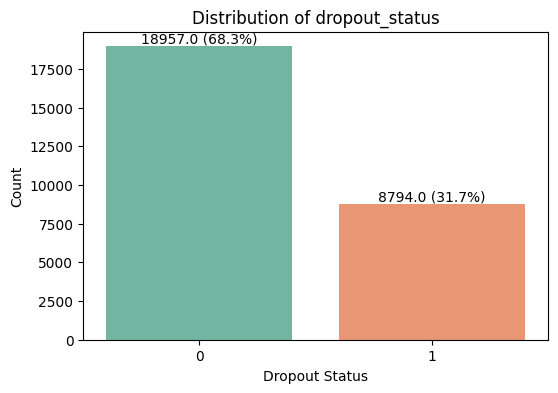

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# 클래스 분포 카운트
plt.figure(figsize=(6,4))
sns.countplot(x='dropout_status', data=df, palette='Set2')

# 그래프에 비율 표시
total = len(df)
for p in plt.gca().patches:
    count = p.get_height()
    plt.gca().annotate(f'{count} ({count/total:.1%})', 
                       (p.get_x() + p.get_width() / 2., count),
                       ha='center', va='bottom', fontsize=10)

plt.title('Distribution of dropout_status')
plt.xlabel('Dropout Status')
plt.ylabel('Count')
plt.show()
